In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from flask import Flask, request, jsonify

In [ ]:
!pip install imbalanced-learn

In [ ]:
# Load dataset
df = pd.read_csv("/content/bankruptcy-prevention(edited).csv")

In [ ]:
# Strip column names (removes any extra spaces)
df.columns = df.columns.str.strip()

In [ ]:
df.head()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy


In [ ]:
df.shape

(250, 7)

In [ ]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 250 rows and 7 columns.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        250 non-null    float64
 1   management_risk        250 non-null    float64
 2   financial_flexibility  250 non-null    float64
 3   credibility            250 non-null    float64
 4   competitiveness        250 non-null    float64
 5   operating_risk         250 non-null    float64
 6   class                  250 non-null    object 
dtypes: float64(6), object(1)
memory usage: 13.8+ KB


In [ ]:
df.isnull().sum()

,0
industrial_risk,0
management_risk,0
financial_flexibility,0
credibility,0
competitiveness,0
operating_risk,0
class,0


In [ ]:
duplicate_count =df.duplicated().sum()

In [ ]:
duplicate_count

147

Statistical Summary

In [ ]:
df.describe()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.518000,0.614000,0.376000,0.470000,0.476000,0.570000
std,0.411526,0.410705,0.401583,0.415682,0.440682,0.434575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


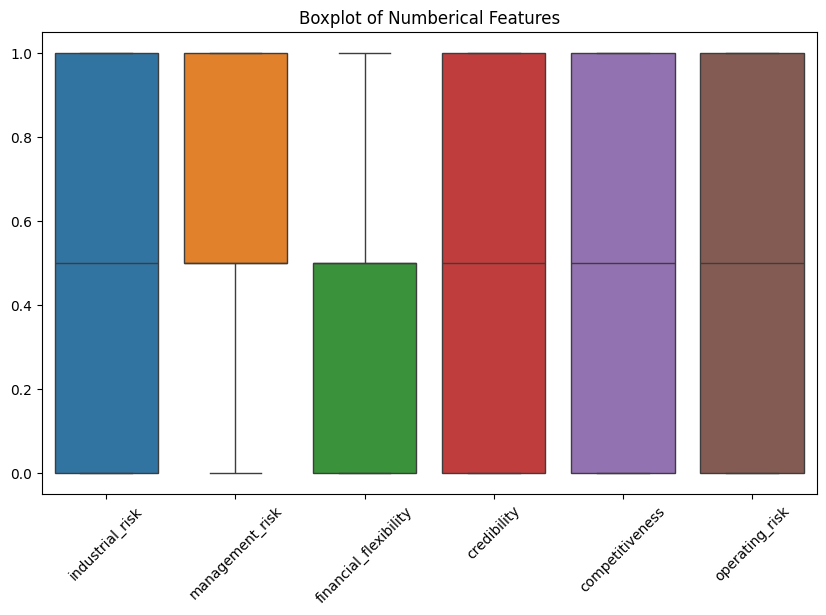

In [ ]:
#Boxplot to visualize outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Numberical Features")
plt.show()

<ipython-input-20-c7d99e6e7a37>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='class',palette='coolwarm')


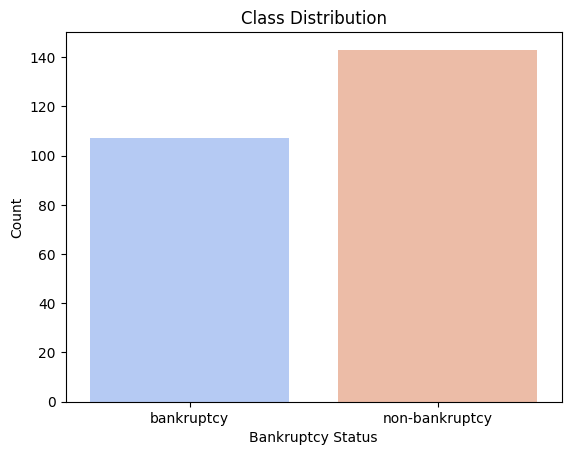

In [ ]:
#class distribution
#visualize class distribution
sns.countplot(data=df,x='class',palette='coolwarm')
plt.title('Class Distribution')
plt.xlabel('Bankruptcy Status')
plt.ylabel('Count')
plt.show()

In [ ]:
#Convert class labels to numeric (0- non-bankruptcy, 1= Bankruptcy)
df['class'] = df['class'].map({'non-bankruptcy':0,'bankruptcy':1})

In [ ]:
#print class distribution
df['class'].value_counts(normalize=True)*100

,proportion
class,
0,57.2
1,42.8


In [ ]:
#Compute correlation matrix
correlation_matrix =df.corr()


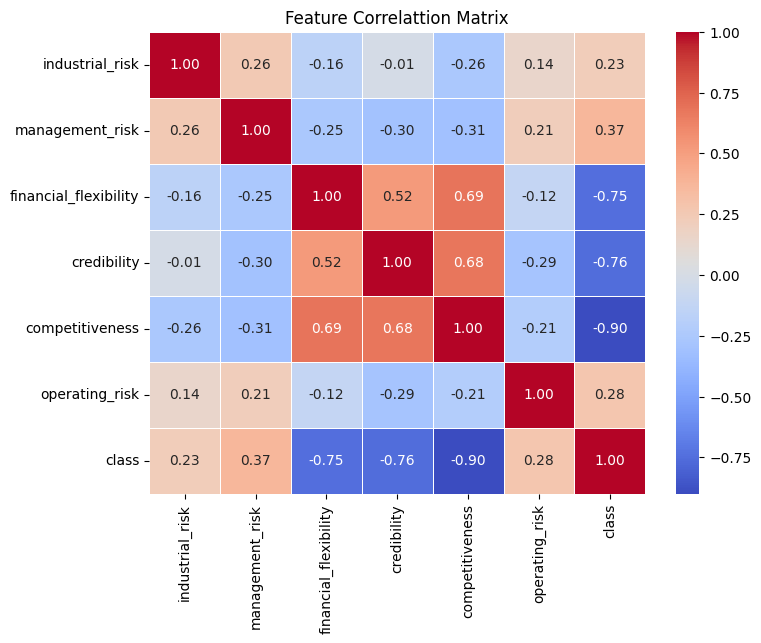

In [ ]:
#plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm',fmt='.2f',linewidths=0.5)
plt.title('Feature Correlattion Matrix')
plt.show()

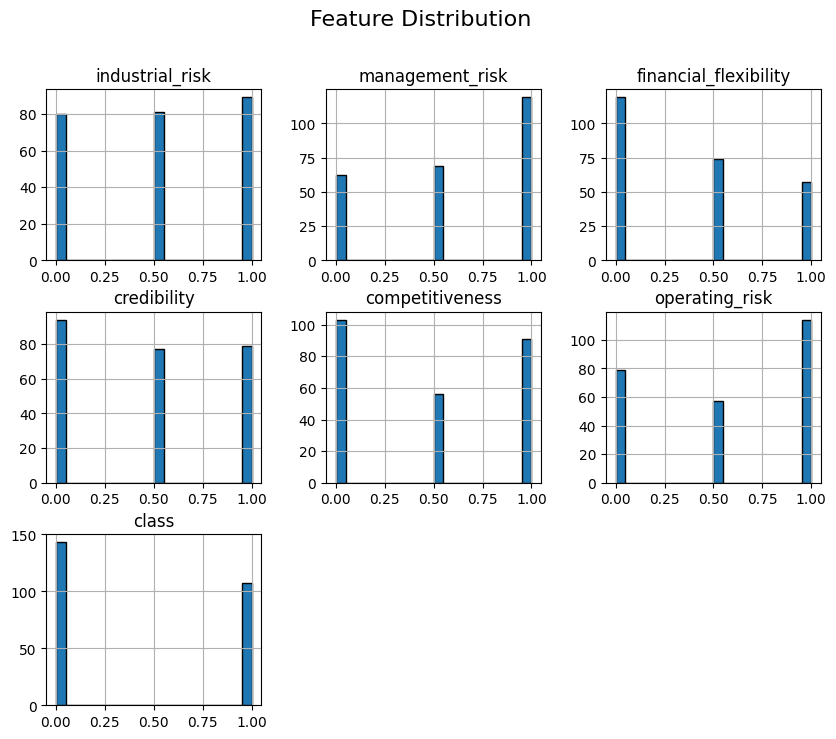

In [ ]:
#Histrogram for all features
df.hist(figsize=(10,8),bins=20,edgecolor='black')
plt.suptitle("Feature Distribution",fontsize=16)
plt.show()

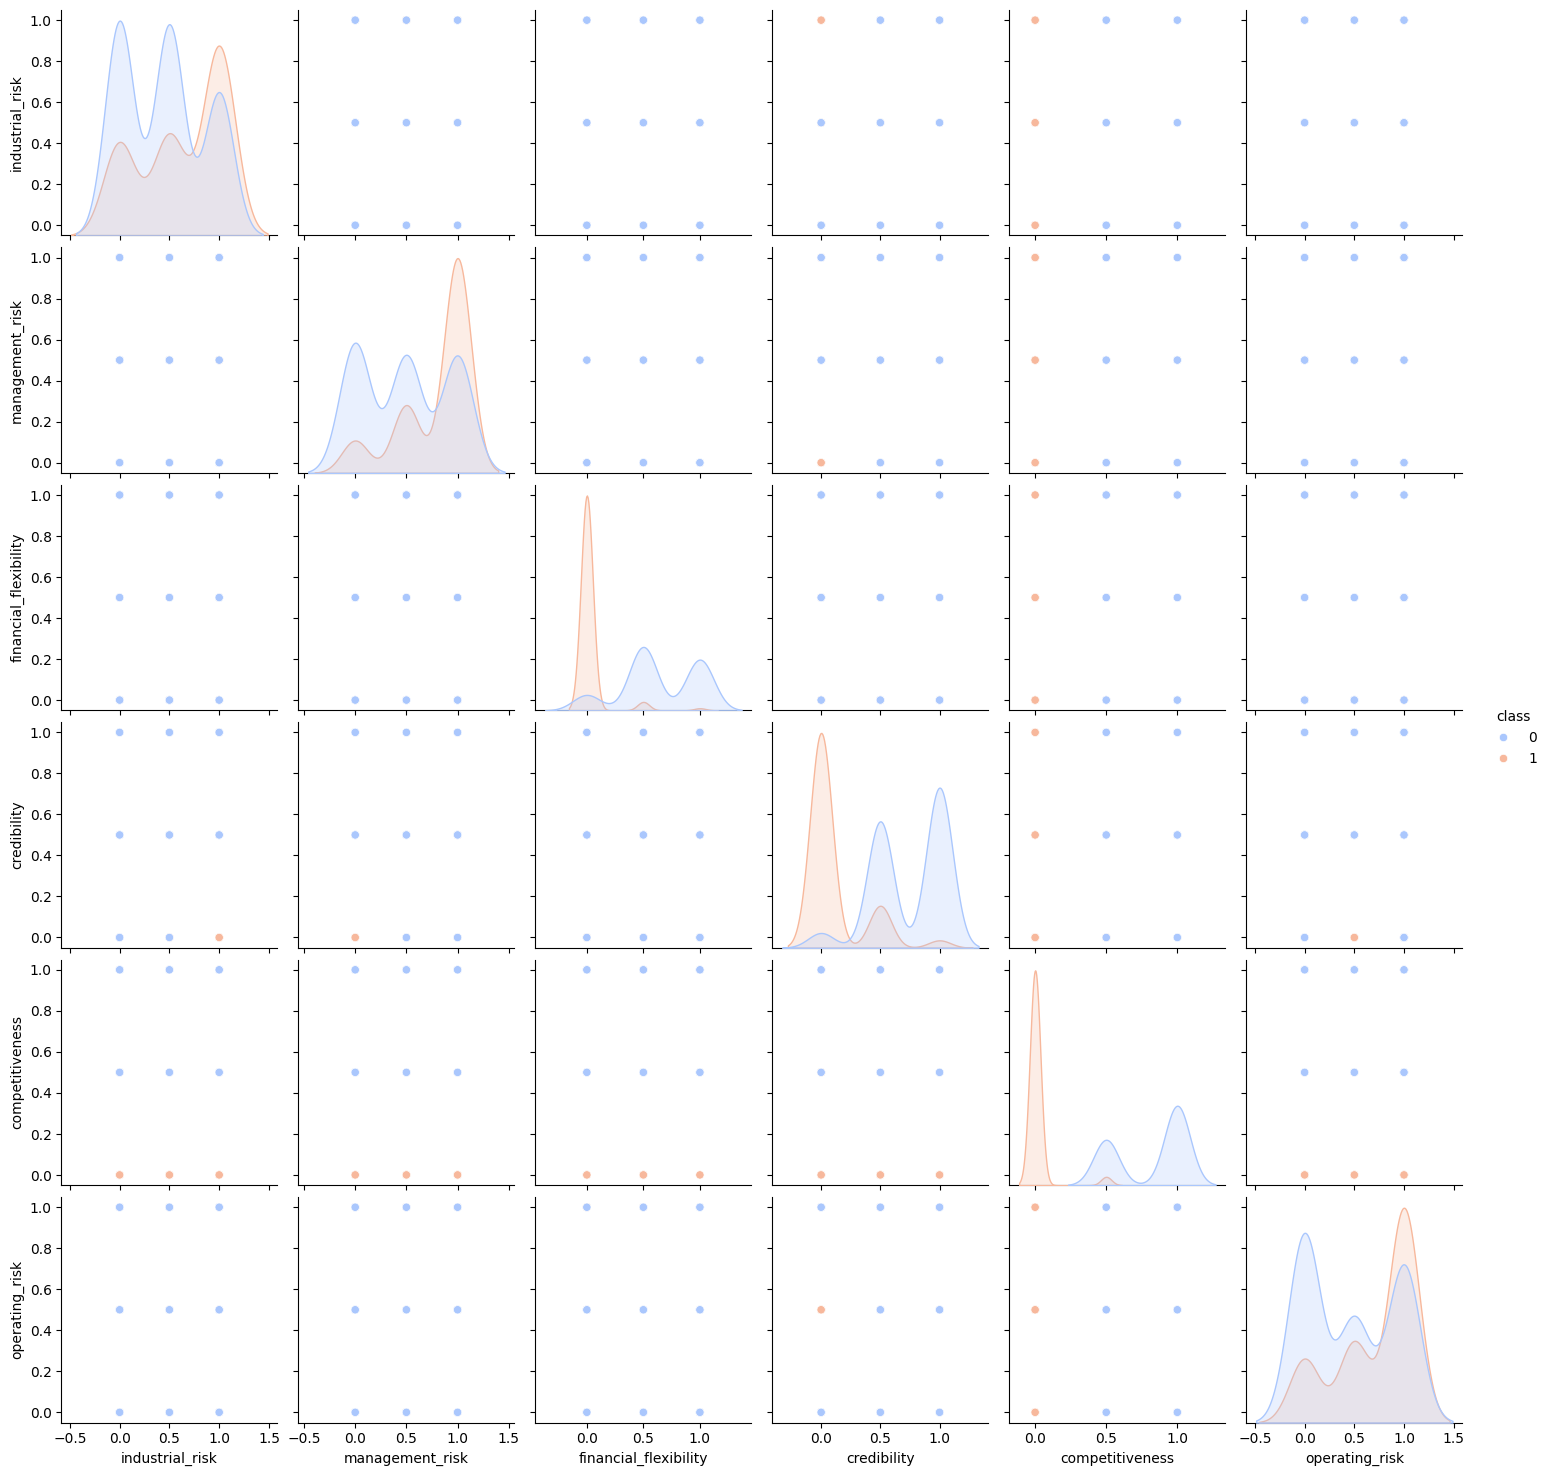

In [ ]:
#Pairplot for feature Relationships
sns.pairplot(df, hue="class",palette="coolwarm")
plt.show()

In [ ]:
#Ordinal Encoding for Features
encoder= OrdinalEncoder()
df.iloc[:,:-1]=encoder.fit_transform(df.iloc[:,:-1])

In [ ]:
#Define features and Target
x = df.drop(columns=['class'])
y = df['class']

In [ ]:
# Feature Selection (Selecting top 4 features based on ANOVA F-statistic)
selector = SelectKBest(score_func=f_classif, k=4)
X_selected = selector.fit_transform(x, y)
selected_features = x.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['management_risk', 'financial_flexibility', 'credibility',
       'competitiveness'],
      dtype='object')


In [ ]:
 #Train-Test split (80-20)
X_train, X_test, y_train,y_test =train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
#Standardization (for XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Define Class Weights for Imbalance Handling
class_weights = dict(pd.Series(y_train).value_counts(normalize=True))
weight_0 = class_weights[0]  #Non-brankruptcy
weight_1 = class_weights[1]  #Bankruptcy

In [ ]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(class_weight={0: weight_0, 1: weight_1}, random_state=42))
])

In [ ]:
# Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(class_weight={0: weight_0, 1: weight_1}, random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_


In [ ]:
# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('classifier', XGBClassifier(scale_pos_weight=weight_0/weight_1, random_state=42))
])

In [ ]:
# Hyperparameter Tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb_model = XGBClassifier(scale_pos_weight=weight_0/weight_1, random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid_search.best_estimator_


In [ ]:
# Predictions
rf_preds = best_rf_model.predict(X_test)
xgb_preds = best_xgb_model.predict(X_test_scaled)

In [ ]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:\n")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# Evaluate Both Models
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")


Random Forest Performance:

Accuracy: 1.0
Confusion Matrix:
 [[29  0]
 [ 0 21]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50


XGBoost Performance:

Accuracy: 0.98
Confusion Matrix:
 [[28  1]
 [ 0 21]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.95      1.00      0.98        21

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [42]:
from sklearn.linear_model import LogisticRegression

In [44]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [45]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



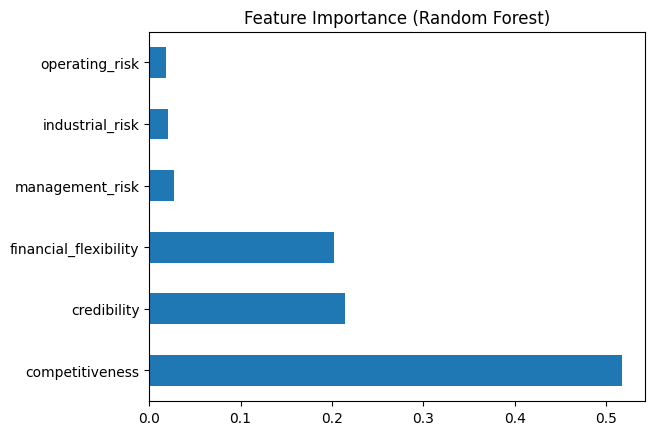

In [ ]:
selected_features = X_train.columns
# Feature Importance Plot
feat_importances = pd.Series(best_rf_model.feature_importances_, index=selected_features)
feat_importances.nlargest(len(selected_features)).plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.show()

In [46]:
# Save Models for Deployment
joblib.dump(best_rf_model, "random_forest_model.pkl")
joblib.dump(best_xgb_model, "xgboost_model.pkl")
joblib.dump(model_lr,"Logistic_Reg.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']